In [ ]:
%cd /content/

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip /content/drive/MyDrive/Colab\ Notebooks/MEDAI_MAR/abdomen/data.zip

In [ ]:
# !zip -r /content/data/Abdomen/data.zip /content/data

In [ ]:
# import shutil
# shutil.move("/content/data/Abdomen/data.zip", "/content/drive/MyDrive/Colab Notebooks/MEDAI_MAR/abdomen")

In [ ]:
!gdown 18I9JHH_i0uuEDg-N6d7bfMdf7Ut6bhBi
!unzip -xq ./data.zip

Downloading...
From (original): https://drive.google.com/uc?id=18I9JHH_i0uuEDg-N6d7bfMdf7Ut6bhBi
From (redirected): https://drive.google.com/uc?id=18I9JHH_i0uuEDg-N6d7bfMdf7Ut6bhBi&confirm=t&uuid=99fd26e1-f202-49cd-b058-8ae13fe41d15
To: /content/data.zip
100% 610M/610M [00:07<00:00, 79.8MB/s]


In [ ]:
!mkdir lists

In [ ]:
!pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 10.1 MB/s eta 0:00:00


In [ ]:
!pip install seg-metrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 28.3 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import torch
import warnings
import ipywidgets
import numpy as np
import pandas as pd
from torch import nn
import nibabel as nib
from glob import glob
from PIL import Image
from torchsummary import summary
import torch.optim as optim
# from unet3d import UNet3d
from IPython import display
import matplotlib.pyplot as plt
from skimage.util import montage
from tqdm.autonotebook import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
from keras.preprocessing.image import ImageDataGenerator
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.tensorboard import SummaryWriter
import torch.optim.lr_scheduler as lr_scheduler
import SimpleITK as sitk
import logging
import torch.backends.cudnn as cudnn
import sys
import seg_metrics.seg_metrics as sg
cfg_path= '/content/content/data/Abdomen/RawData/Training'

<ipython-input-10-b809c31af029>:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
import os
import random
import h5py
import numpy as np
import torch
from scipy import ndimage
from scipy.ndimage import zoom
from torch.utils.data import Dataset
from torchvision import transforms


def random_rot_flip(image, label):
    k = np.random.randint(0, 4)
    image = np.rot90(image, k)
    label = np.rot90(label, k)
    axis = np.random.randint(0, 2)
    image = np.flip(image, axis=axis).copy()
    label = np.flip(label, axis=axis).copy()
    return image, label


def random_rotate(image, label):
    angle = np.random.randint(-20, 20)
    image = ndimage.rotate(image, angle, order=0, reshape=False)
    label = ndimage.rotate(label, angle, order=0, reshape=False)
    return image, label


class RandomGenerator(object):
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        if random.random() > 0.5:
            image, label = random_rot_flip(image, label)
        elif random.random() > 0.5:
            image, label = random_rotate(image, label)
        x, y = image.shape
        if x != self.output_size[0] or y != self.output_size[1]:
            image = zoom(image, (self.output_size[0] / x, self.output_size[1] / y), order=3)  # why not 3?
            label = zoom(label, (self.output_size[0] / x, self.output_size[1] / y), order=0)
        image = torch.from_numpy(image.astype(np.float32)).unsqueeze(0)
        label = torch.from_numpy(label.astype(np.float32))
        sample = {'image': image, 'label': label.long()}
        return sample


class Synapse_dataset(Dataset):
    def __init__(self, base_dir, list_dir, split, transform=None):
        self.transform = transform  # using transform in torch!
        self.split = split
        self.sample_list = open(os.path.join(list_dir, self.split+'.txt')).readlines()
        self.data_dir = base_dir

    def __len__(self):
        return len(self.sample_list)

    def __getitem__(self, idx):
        if self.split == "train":
            slice_name = self.sample_list[idx].strip('\n')
            data_path = os.path.join(self.data_dir, slice_name+'.npz')
            data = np.load(data_path)
            image, label = data['image'], data['label']
            # print(image.shape)
        else:
            vol_name = self.sample_list[idx].strip('\n')
            filepath = self.data_dir + "/{}.npy.h5".format(vol_name)
            data = h5py.File(filepath)
            image, label = data['image'][:], data['label'][:]

        sample = {'image': image, 'label': label}
        if self.transform:
            sample = self.transform(sample)
        sample['case_name'] = self.sample_list[idx].strip('\n')
        return sample

In [ ]:
root_path= '/content/data/Synapse/train_npz'
list_dir= '/content/lists'
img_size= 224

db_train = Synapse_dataset(base_dir=root_path, list_dir=list_dir, split="train",
                               transform=transforms.Compose(
                                   [RandomGenerator(output_size=[img_size, img_size])]))

In [ ]:
sample= db_train.__getitem__(0)

print(sample['label'].shape)

torch.Size([224, 224])


In [ ]:
test_path= '/content/data/Synapse/test_vol_h5'

db_test = Synapse_dataset(base_dir=test_path, split="test_vol", list_dir=list_dir)
testloader = DataLoader(db_test, batch_size=1, shuffle=False, num_workers=1)

In [ ]:
print("The length of train set is: {}".format(len(db_train)))

The length of train set is: 2211


In [ ]:
batch_size= 10
trainloader = DataLoader(db_train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True,)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class REBNCONV(nn.Module):
    def __init__(self,in_ch=3,out_ch=3,dirate=1):
        super(REBNCONV,self).__init__()

        self.conv_s1 = nn.Conv2d(in_ch,out_ch,3,padding=1*dirate,dilation=1*dirate)
        self.bn_s1 = nn.BatchNorm2d(out_ch)
        self.relu_s1 = nn.ReLU(inplace=True)

    def forward(self,x):

        hx = x
        xout = self.relu_s1(self.bn_s1(self.conv_s1(hx)))

        return xout

## upsample tensor 'src' to have the same spatial size with tensor 'tar'
def _upsample_like(src,tar):

    src = F.upsample(src,size=tar.shape[2:],mode='bilinear')

    return src


### RSU-6 ###
class RSU6(nn.Module):#UNet07DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=128, out_ch=1):
        super(RSU6,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)
        # self.pool5 = nn.MaxPool3d(2,stride=2,ceil_mode=True)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=2)

        # self.rebnconv7 = REBNCONV(mid_ch,mid_ch,dirate=2)

        # self.rebnconv6d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,mid_ch,dirate=1)

        self.side1 = nn.Conv2d(mid_ch,out_ch,3,padding=1)
        self.side2 = nn.Conv2d(mid_ch,out_ch,3,padding=1)
        self.side3 = nn.Conv2d(mid_ch,out_ch,3,padding=1)
        self.side4 = nn.Conv2d(mid_ch,out_ch,3,padding=1)
        self.side5 = nn.Conv2d(mid_ch,out_ch,3,padding=1)
        self.side6 = nn.Conv2d(mid_ch,out_ch,3,padding=1)

        self.outconv = nn.Conv2d(6*out_ch,out_ch,1)


    def forward(self,x, test= False):

        hx = x
        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)

        hx6 = self.rebnconv6(hx5)

        # hx7 = self.rebnconv7(hx6)

        # hx6d =  self.rebnconv6d(torch.cat((hx7,hx6),1))
        # hx6dup = _upsample_like(hx6d,hx5)

        hx5d =  self.rebnconv5d(torch.cat((hx6,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2,d1)

        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3,d1)

        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4,d1)

        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5,d1)

        d6 = self.side6(hx6)
        d6 = _upsample_like(d6,d1)

        d0 = self.outconv(torch.cat((d1,d2,d3,d4,d5,d6),1))


        # if test:
        #     return nn.Softmax(d0), nn.Softmax(d1), nn.Softmax(d2), nn.Softmax(d3), nn.Softmax(d4), nn.Softmax(d5), nn.Softmax(d6)
        return d0, d1, d2, d3, d4, d5, d6


In [ ]:
net = RSU6(3,128, 14).cuda()

summary(net, input_size=(3,64, 64), batch_size= 1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 14, 64, 64]             392
       BatchNorm2d-2            [1, 14, 64, 64]              28
              ReLU-3            [1, 14, 64, 64]               0
          REBNCONV-4            [1, 14, 64, 64]               0
            Conv2d-5           [1, 128, 64, 64]          16,256
       BatchNorm2d-6           [1, 128, 64, 64]             256
              ReLU-7           [1, 128, 64, 64]               0
          REBNCONV-8           [1, 128, 64, 64]               0
         MaxPool2d-9           [1, 128, 32, 32]               0
           Conv2d-10           [1, 128, 32, 32]         147,584
      BatchNorm2d-11           [1, 128, 32, 32]             256
             ReLU-12           [1, 128, 32, 32]               0
         REBNCONV-13           [1, 128, 32, 32]               0
        MaxPool2d-14           [1, 128,

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [ ]:
from torch.nn.modules.loss import CrossEntropyLoss

class DiceLoss(nn.Module):
    def __init__(self, n_classes):
        super(DiceLoss, self).__init__()
        self.n_classes = n_classes

    def _one_hot_encoder(self, input_tensor):
        tensor_list = []
        for i in range(self.n_classes):
            temp_prob = input_tensor == i  # * torch.ones_like(input_tensor)
            tensor_list.append(temp_prob.unsqueeze(1))
        output_tensor = torch.cat(tensor_list, dim=1)
        return output_tensor.float()

    def _dice_loss(self, score, target):
        target = target.float()
        smooth = 1e-5
        intersect = torch.sum(score * target)
        y_sum = torch.sum(target * target)
        z_sum = torch.sum(score * score)
        loss = (2 * intersect + smooth) / (z_sum + y_sum + smooth)
        loss = 1 - loss
        return loss

    def forward(self, inputs, target, weight=None, softmax=False):

        if softmax:
            inputs = torch.softmax(inputs, dim=1)
        target = self._one_hot_encoder(target.squeeze(1))
        if weight is None:
            weight = [1] * self.n_classes
        #print(inputs)
        assert inputs.size() == target.size(), 'predict {} & target {} shape do not match'.format(inputs.size(), target.size())
        class_wise_dice = []
        loss = 0.0
        for i in range(0, self.n_classes):
            dice = self._dice_loss(inputs[:, i], target[:, i])
            class_wise_dice.append(1.0 - dice.item())
            loss += dice * weight[i]
        return loss / self.n_classes


In [ ]:
# from torch.nn.modules.loss import _Loss

# class CCEDiceLoss(nn.Module):

#   def __init__(self,
#               #  to_onehot_y: bool = False,
#               #  sigmoid: bool = False,
#                 # softmax: bool = False,
#                smooth_nr: float = 1e-5,
#                smooth_dr: float = 1e-5,
#                ):
#     super().__init__()
#     # self.to_onehot_y = to_onehot_y
#     # self.sigmoid = sigmoid
#     self.smooth_nr= smooth_nr
#     self.smooth_dr= smooth_dr


#     # self.softmax = softmax
#   def forward(self, input, target):
#     # if self.sigmoid:
#     # cce_tar= target
#     # cce = nn.CrossEntropyLoss()
#     # cce_l= cce(input,cce_tar.squeeze(1).long())
#     # print(input.shape, 'inputs')
#     sfm= torch.nn.Softmax(dim= 1)
#     input= sfm(input)
#     n_pred_ch= input.shape[1]
#     target = one_hot(target, num_classes=n_pred_ch, dim= 1)
#     if target.shape != input.shape:
#       raise AssertionError(f"ground truth has different shape ({target.shape}) from input ({input.shape})")
#     # reducing, summing - only spatial dimensions (not batch nor channels)
#     reduce_axis: list[int] = torch.arange(2, len(input.shape)).tolist()
#     intersection = torch.sum(target * input, dim=reduce_axis)
#     ground_o = torch.sum(target, dim=reduce_axis)
#     pred_o = torch.sum(input, dim=reduce_axis)
#     denominator = ground_o + pred_o
#     f: torch.Tensor = 1.0 - (2.0 * intersection + self.smooth_nr) / (denominator + self.smooth_dr)
#     num_of_classes = target.shape[1]
#     f = torch.mean(f)
#     return f

class AbdomenNetLoss(nn.Module):
  def __init__(self, num_classes):
    super(AbdomenNetLoss, self).__init__()
    self.loss = DiceLoss(num_classes)

  def forward(self, d0, d1, d2, d3, d4, d5, d6, labels_v, softmax= True):
    loss0 = self.loss(d0, labels_v, softmax= True)
    loss1 = self.loss(d1, labels_v, softmax= True)
    loss2 = self.loss(d2, labels_v, softmax= True)
    loss3 = self.loss(d3, labels_v, softmax= True)
    loss4 = self.loss(d4, labels_v, softmax= True)
    loss5 = self.loss(d5, labels_v, softmax= True)
    loss6 = self.loss(d6, labels_v, softmax= True)
    loss = loss0 + loss1 + loss2 + loss3 + loss4 + loss5 + loss6
    print("l0: %3f, l1: %3f, l2: %3f, l3: %3f, l4: %3f, l5: %3f, l6: %3f\n" % (
        loss0.data, loss1.data, loss2.data, loss3.data, loss4.data, loss5.data, loss6.data,))
    return loss0, loss

# 25, 14, 4, 128, 128

In [ ]:
kwargs= {
    'name' : 'AbdomenNet',
    'fold': 0,
    'epochs' : 40,
    'batch_size': 50,
    'input_channels': 1,
    'num_classes' : 1,
    'input_size': 64,
    'data_folder_name': 'train_data',
    'optimizer': 'Adam',
    'lr': 0.001,
    'nesterov': False,
    'momentum': 0.9,
    'weight_decay': 1e-4,
    'scheduler': 'CosineAnnealingLR',
    'min_lr': 1e-7,
    'factor': 0.1,
    'patience': 3,
    'milestones': '1,2',
    'gamma' : 2/3,
    'early_stopping' : 1,
    'num_workers':4
}

In [ ]:
class Model_Train():
  def __init__(self ,train_loader, **kwargs):
      self.model_loss = AbdomenNetLoss(num_classes= 14)
      self.model_name = kwargs['name']
      self.epoch_num = kwargs['epochs']
      self.save_frq = 3500  # save the model every 1000 iterations
      self.batch_size_train = kwargs['batch_size']
      self.epoch = 0
      self.model_dir= '/content/drive/MyDrive/Colab Notebooks/MEDAI_MAR/'

      self.root_dir = "/content/"
      self.log_dir = os.path.join(self.root_dir, "logs/my_board/" + os.sep)
      self.pthFile_name = "NONE"
      self.writer = SummaryWriter(self.log_dir)
      self.abdomen_dataloader= train_loader


      print("---")
      print("train images: ", len(self.abdomen_dataloader))
      print("train labels: ", len(self.abdomen_dataloader))
      print("---")
      self.train_num = len(self.abdomen_dataloader)*kwargs['batch_size']
      # glioma_dataloader = Glioma_dataloader(img_name_list=tra_img_name_list, lbl_name_list=tra_lbl_name_list,
      #                                       transform= train_transforms)

                                      # transform=transforms.Compose([RescaleT(kwargs['input_size']), ToTensorLab(flag=0)]), )
      # train_loaders[kwargs['fold']] = AugDataLoader(ds, batch_size = self.batch_size_train, sampler = self.train_sampler)
      # self.abdomen_dataloader = train_loaders[kwargs['fold']]
      self.model = RSU6(in_ch = 3, mid_ch=256 ,out_ch= 14).cuda()
      # self.model= DexiNed().cuda()

      params = filter(lambda p: p.requires_grad, self.model.parameters())
      if kwargs['optimizer'] == 'Adam':
        self.optimizer = optim.Adam(params, lr=kwargs['lr'], betas=(0.9, 0.999), eps=1e-08,weight_decay=0, ) #weight_decay=config['weight_decay'])
      elif kwargs['optimizer'] == 'SGD':
        self.optimizer = optim.SGD(params, lr=kwargs['lr'], momentum=kwargs['momentum'], nesterov=kwargs['nesterov'],weight_decay=kwargs['weight_decay'])
      else:
        raise NotImplementedError

      if kwargs['scheduler'] == 'CosineAnnealingLR':
        self.scheduler = lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=kwargs['epochs'], eta_min=kwargs['min_lr'])
      elif kwargs['scheduler'] == 'ReduceLROnPlateau':
        self.scheduler = lr_scheduler.ReduceLROnPlateau(self.optimizer, factor=kwargs['factor'], patience=kwargs['patience'],
                                                      verbose=1, min_lr=kwargs['min_lr'])
      elif kwargs['scheduler'] == 'MultiStepLR':
        self.scheduler = lr_scheduler.MultiStepLR(self.optimizer,
                                                milestones=[int(e) for e in kwargs['milestones'].split(',')],
                                                gamma=kwargs['gamma'])
      elif kwargs['scheduler'] == 'ConstantLR':
        self.scheduler = None
      else:
        raise NotImplementedError
  def model_train(self):
    if self.pthFile_name != "NONE":
      checkpoint = torch.load(self.pthFile_name)
      print("Pretrained Model - Started for training")
      if checkpoint["epoch"] > 0:
        self.model.load_state_dict(checkpoint["model_state_dict"])
        epoch = checkpoint["epoch"]
        print(f"=====> epoch:{epoch}")
        if torch.cuda.is_available():
          self.model.cuda()
          # ------- 4. define optimizer --------
        print("---define optimizer on retraining...")
        # self.optimizer = optim.Adam(self.model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08,weight_decay=0, )
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
      else:
        if torch.cuda.is_available():
            self.model.cuda()
        # ------- 4. define optimizer --------
        print("---define optimizer...")
        #self.optimizer = optim.Adam(self.model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08,weight_decay=0, )
    else:
      if torch.cuda.is_available():
        self.model.cuda()
      # ------- 4. define optimizer --------
      print("---define optimizer...")
      # self.optimizer = optim.Adam(self.model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, )

      # ------- 5. training process --------
    print("---start training...")
    ite_num = 0
    running_loss = 0.0
    running_tar_loss = 0.0
    ite_num4val = 0
    while self.epoch < self.epoch_num:
      self.model.train()
      for i, sampled_batch in enumerate(self.abdomen_dataloader):
        ite_num = ite_num + 1
        ite_num4val = ite_num4val + 1

        inputs, labels = sampled_batch['image'], sampled_batch['label']
        inputs = inputs.type(torch.FloatTensor)
        labels = labels.type(torch.FloatTensor)

        B, C, H, W = inputs.shape
        inputs = inputs.expand(B, 3, H, W)

        if torch.cuda.is_available():
          inputs_v, labels_v = (
          Variable(inputs.cuda(), requires_grad=False), Variable(labels.cuda(), requires_grad=False),)
        else:
          inputs_v, labels_v = Variable(inputs, requires_grad=False), Variable(labels, requires_grad=False)

        # y zero the parameter gradients
        self.optimizer.zero_grad()
        # print(inputs_v.shape)
        # forward + backward + optimize
        d0, d1, d2, d3, d4, d5, d6 = self.model(inputs_v, test= False)
        # print(d0.shape)
        loss2, loss = self.model_loss(d0, d1, d2, d3, d4, d5, d6, labels_v, softmax= True)
        loss.backward()
        self.optimizer.step()
        # # print statistics
        running_loss += loss.data
        running_tar_loss += loss2.data
        # del temporary outputs and loss
        del d0, d1, d2, d3, d4, d5, d6,loss2, loss
        print("[epoch: %3d/%3d, batch: %5d/%5d, ite: %d] train loss: %3f, tar: %3f " % (
            self.epoch + 1, self.epoch_num, (i + 1) * self.batch_size_train, self.train_num, ite_num,
            running_loss / ite_num4val,
            running_tar_loss / ite_num4val,))

        self.writer.add_scalar("train loss", running_loss / ite_num4val, self.epoch + 1)
        self.writer.add_scalar("tar loss", running_tar_loss / ite_num4val)

        if ite_num % self.save_frq == 0:
          torch.save({"epoch": self.epoch, "model_state_dict": self.model.state_dict(),
                      "optimizer_state_dict": self.optimizer.state_dict(), },
                      self.model_dir + self.model_name + "_%d_at3_Unet3d_bce_itr_%d_train_%3f_tar_%3f.pth" % (
                      self.epoch, ite_num, running_loss / ite_num4val, running_tar_loss / ite_num4val,), )
          running_loss = 0.0
          running_tar_loss = 0.0
          self.model.train()  # resume train
          ite_num4val = 0

      self.epoch = self.epoch + 1
      self.scheduler.step()
      print(f"Current Learning Rate:{self.optimizer.param_groups[0]['lr']} ")

    torch.save(
        {"epoch": self.epoch, "model_state_dict": self.model.state_dict(),
          "optimizer_state_dict": self.optimizer.state_dict(), },
        self.model_dir + self.model_name + "_%d_at3_final_Unet3d_bce_itr_%d_train_%3f_tar_%3f.pth" % (
        self.epoch, ite_num, running_loss / ite_num4val, running_tar_loss / ite_num4val,), )



In [ ]:
model_obj = Model_Train(trainloader, **kwargs)
model_obj.model_train()

Streaming output truncated to the last 5000 lines.
l0: 0.107310, l1: 0.106548, l2: 0.235334, l3: 0.046917, l4: 0.196240, l5: 0.223794, l6: 0.159163

[epoch:  33/ 40, batch:  5650/11100, ite: 7217] train loss: 1.064479, tar: 0.095819 
l0: 0.106360, l1: 0.106152, l2: 0.233088, l3: 0.054966, l4: 0.201203, l5: 0.231841, l6: 0.168374

[epoch:  33/ 40, batch:  5700/11100, ite: 7218] train loss: 1.064651, tar: 0.095867 
l0: 0.090977, l1: 0.093181, l2: 0.091856, l3: 0.093895, l4: 0.167865, l5: 0.318371, l6: 0.243825

[epoch:  33/ 40, batch:  5750/11100, ite: 7219] train loss: 1.064813, tar: 0.095845 
l0: 0.121167, l1: 0.125911, l2: 0.243783, l3: 0.072637, l4: 0.196704, l5: 0.217261, l6: 0.148449

[epoch:  33/ 40, batch:  5800/11100, ite: 7220] train loss: 1.065090, tar: 0.095960 
l0: 0.108410, l1: 0.109218, l2: 0.237177, l3: 0.043844, l4: 0.187280, l5: 0.219910, l6: 0.156228

[epoch:  33/ 40, batch:  5850/11100, ite: 7221] train loss: 1.065077, tar: 0.096016 
l0: 0.086401, l1: 0.084328, l2: 0.

In [ ]:
path_= '/content/drive/MyDrive/Colab Notebooks/MEDAI_MAR/AbdomenNet_40_at3_final_Unet3d_bce_itr_8880_train_1.039858_tar_0.092845.pth'

sample_model =RSU6(3, 256, 14).cuda()

checkpoint = torch.load(path_)

sample_model.load_state_dict(checkpoint['model_state_dict'])
optimizer = optim.Adam(sample_model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08,weight_decay=0, )

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print("Model loaded!")

Model loaded!


In [ ]:
from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.bool` is a deprecated alias')

In [ ]:
swargs={
    'model_name': 'Abdomenet',
    'list_dir': '/content/lists',
    'num_classes': 14,
    'deterministic': 1,
    'img_size': 224,
    'seed': 1234,
    'output_dir': '/content/data/preds',
    'z_spacing': 1,
    'is_savenii': True,
    'test_save_dir': '/content/data/preds',
    'test_path': '/content/data/Synapse/test_vol_h5'
}

# model = RSU6(in_ch = 3, mid_ch=128 ,out_ch= 14).cuda()

In [ ]:
# def calculate_metric_percase(pred, gt):
#     pred[pred > 0] = 1
#     gt[gt > 0] = 1
#     if pred.sum() > 0 and gt.sum()>0:
#         dice = metric.binary.dc(pred, gt)
#         hd95 = metric.binary.hd95(pred, gt)
#         return dice, hd95
#     elif pred.sum() > 0 and gt.sum()==0:
#         return 1, 0
#     else:
#         return 0, 0

def test_single_volume(image, label, net, classes, patch_size=[256, 256], test_save_path=None, case=None, z_spacing=1):
    image, label = image.squeeze(0).cpu().detach().numpy(), label.squeeze(0).cpu().detach().numpy()
    if len(image.shape) == 3:
        prediction = np.zeros_like(label)
        for ind in range(image.shape[0]):
            slice = image[ind, :, :]
            x, y = slice.shape[0], slice.shape[1]
            if x != patch_size[0] or y != patch_size[1]:
                slice = zoom(slice, (patch_size[0] / x, patch_size[1] / y), order=3)  # previous using 0
            input = torch.from_numpy(slice).unsqueeze(0).unsqueeze(0).float().cuda()

            B, C, H, W = input.shape
            input = input.expand(B, 3, H, W)

            net.eval()
            with torch.no_grad():
                # print(input.shape)
                outputs, _,_, _, _,_, _ = net(input)
                # print(outputs.shape)
                out = torch.argmax(torch.softmax(outputs, dim=1), dim=1).squeeze(0)
                out = out.cpu().detach().numpy()
                if x != patch_size[0] or y != patch_size[1]:
                    pred = zoom(out, (x / patch_size[0], y / patch_size[1]), order=0)
                else:
                    pred = out
                prediction[ind] = pred
    else:
        input = torch.from_numpy(image).unsqueeze(
            0).unsqueeze(0).float().cuda()
        net.eval()
        with torch.no_grad():
            out = torch.argmax(torch.softmax(net(input), dim=1), dim=1).squeeze(0)
            prediction = out.cpu().detach().numpy()
    # metric_list = []
    # for i in range(1, classes):
    #     metric_list.append(sg.write_metrics(labels=classes , gdth_img == i, pred_img == i,csv_file='metrics.csv', metrics=['hd', 'hd95', 'msd']))
    print(image.shape, label.shape, prediction.shape, "ILP")

    if test_save_path is not None:
        img_itk = sitk.GetImageFromArray(image.astype(np.float32))
        prd_itk = sitk.GetImageFromArray(prediction.astype(np.float32))
        lab_itk = sitk.GetImageFromArray(label.astype(np.float32))
        img_itk.SetSpacing((1, 1, z_spacing))
        prd_itk.SetSpacing((1, 1, z_spacing))
        lab_itk.SetSpacing((1, 1, z_spacing))
        sitk.WriteImage(prd_itk, test_save_path + '/'+case + "_pred.nii.gz")
        sitk.WriteImage(img_itk, test_save_path + '/'+ case + "_img.nii.gz")
        sitk.WriteImage(lab_itk, test_save_path + '/'+ case + "_gt.nii.gz")
    # return metric_list

In [ ]:
def inference( testloader, model, test_save_path=None, **swargs):
    logging.info("{} test iterations per epoch".format(len(testloader)))
    model.eval()
    metric_list = 0.0

    for i_batch, sampled_batch in tqdm(enumerate(testloader)):
        h, w = sampled_batch["image"].size()[2:]
        image, label, case_name = sampled_batch["image"], sampled_batch["label"], sampled_batch['case_name'][0]
        print(image.shape)
        test_single_volume(image, label, model, classes=swargs['num_classes'], patch_size=[swargs['img_size'], swargs['img_size']],
                                      test_save_path=test_save_path, case=case_name, z_spacing=swargs['z_spacing'])
        # metric_i = test_single_volume(image, label, model, classes=swargs['num_classes'], patch_size=[swargs['img_size'], swargs['img_size']],
        #                               test_save_path=test_save_path, case=case_name, z_spacing=swargs['z_spacing'])
    #     metric_list += np.array(metric_i)
    #     logging.info(' idx %d case %s mean_dice %f mean_hd95 %f' % (i_batch, case_name, np.mean(metric_i, axis=0)[0], np.mean(metric_i, axis=0)[1]))

    # metric_list = metric_list / len(db_test)

    # for i in range(1, swargs['num_classes']):
    #     logging.info('Mean class %d mean_dice %f mean_hd95 %f' % (i, metric_list[i-1][0], metric_list[i-1][1]))

    # performance = np.mean(metric_list, axis=0)[0]
    # mean_hd95 = np.mean(metric_list, axis=0)[1]

    # logging.info('Testing performance in best val model: mean_dice : %f mean_hd95 : %f' % (performance, mean_hd95))

    # return "Testing Finished!"



if __name__ == "__main__":
    if not swargs['deterministic']:
        cudnn.benchmark = True
        cudnn.deterministic = False
    else:
        cudnn.benchmark = False
        cudnn.deterministic = True
    random.seed(swargs['seed'])
    np.random.seed(swargs['seed'])
    torch.manual_seed(swargs['seed'])
    torch.cuda.manual_seed(swargs['seed'])


    # CONFIGS = {
    #     'hiformer-s': configs.get_hiformer_s_configs(),
    #     'hiformer-b': configs.get_hiformer_b_configs(),
    #     'hiformer-l': configs.get_hiformer_l_configs(),
    # }


    # args.is_pretrain = True

    # model = HiFormer(config=CONFIGS[args.model_name], img_size=args.img_size, n_classes=args.num_classes).cuda()
    # msg = model.load_state_dict(torch.load(args.model_weight))
    # print("HiFormer Model: ", msg)

    log_folder = 'content/test_log/test_log_'
    os.makedirs(log_folder, exist_ok=True)

    logging.basicConfig(filename=log_folder + '/' + swargs['model_name'] + ".txt", level=logging.INFO, format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
    logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
    logging.info(str('Done'))

    if swargs['is_savenii']:
        swargs['test_save_dir'] = os.path.join(swargs['output_dir'], swargs['model_name'])
        test_save_path = swargs['test_save_dir']
        os.makedirs(test_save_path, exist_ok=True)
    else:
        test_save_path = None

    db_test = Synapse_dataset(base_dir=swargs['test_path'], split="test_vol", list_dir=swargs['list_dir'])
    testloader = DataLoader(db_test, batch_size=1, shuffle=False, num_workers=1)

    inference(testloader, sample_model, test_save_path, **swargs)

0it [00:00, ?it/s]

torch.Size([1, 148, 512, 512])


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


(148, 512, 512) (148, 512, 512) (148, 512, 512) ILP
torch.Size([1, 89, 512, 512])


KeyboardInterrupt: 

In [ ]:
train_load = nib.load('/content/data/preds/Abdomenet/case0008_img.nii.gz').get_fdata()
train_load.shape

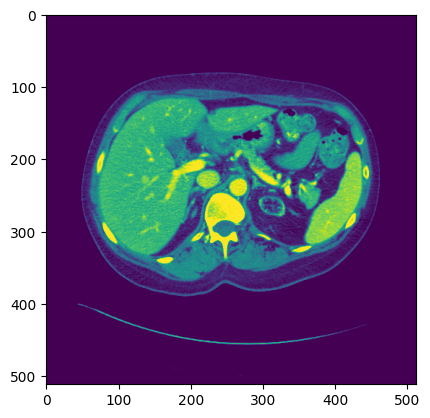

In [ ]:
train = train_load[:,:,114]
plt.imshow(train)
plt.show()

In [ ]:
train_load = nib.load('/content/data/preds/Abdomenet/case0008_gt.nii.gz').get_fdata()
train_load.shape

(512, 512, 148)

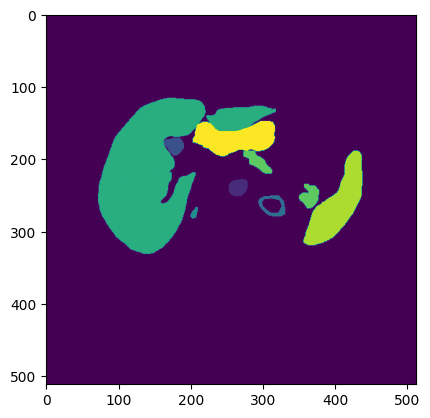

In [ ]:
train = train_load[:,:,114]
plt.imshow(train)
plt.show()

In [ ]:
train_load = nib.load('/content/data/preds/Abdomenet/case0008_pred.nii.gz').get_fdata()
train_load.shape

(512, 512, 148)

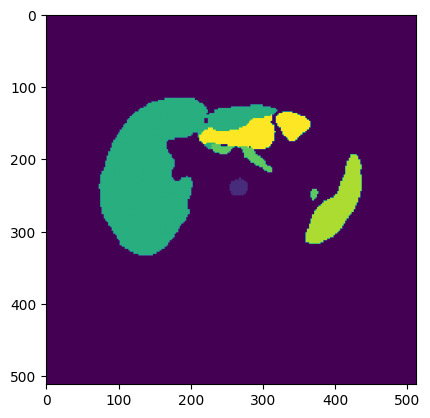

In [ ]:
train = train_load[:,:,114]
plt.imshow(train)
plt.show()

Text(0.5, 1.0, 'Prediction')

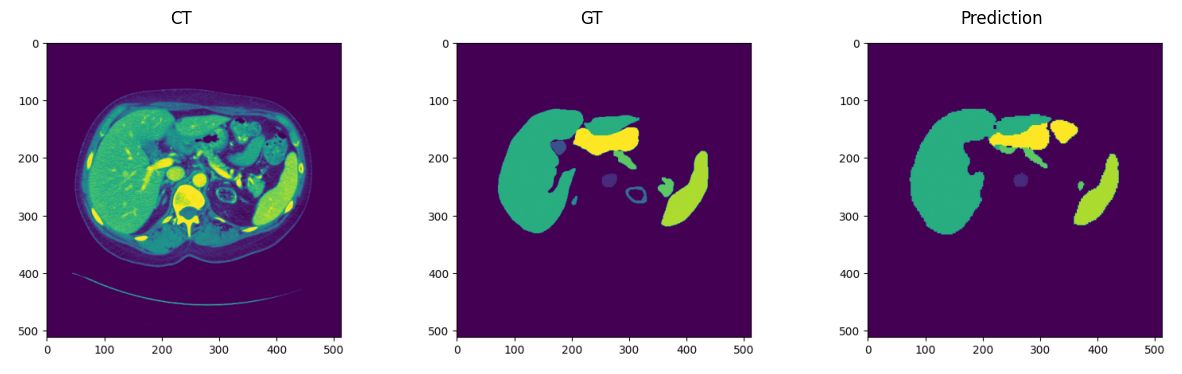

In [ ]:

# code for displaying multiple images in one figure

#import libraries
import cv2
from matplotlib import pyplot as plt

# create figure
fig = plt.figure(figsize=(15, 10))

# setting values to rows and column variables
rows = 1
columns = 3

# reading images
Image1 = cv2.imread('/content/CT_01.png', cv2.IMREAD_UNCHANGED)
Image1 = cv2.cvtColor(Image1, cv2.COLOR_BGR2RGB)
Image2 = cv2.imread('/content/gt_01.png', cv2.IMREAD_UNCHANGED)
Image2 = cv2.cvtColor(Image2, cv2.COLOR_BGR2RGB)
Image3 = cv2.imread('/content/pred_01.png', cv2.IMREAD_UNCHANGED)
Image3 = cv2.cvtColor(Image3, cv2.COLOR_BGR2RGB)
# Image4 = cv2.imread('Image4.jpg')

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(Image1, cmap= 'bone')
plt.axis('off')
plt.title("CT")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(Image2, cmap= 'jet')
plt.axis('off')
plt.title("GT")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)

# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("Prediction")
